### Importing Necessary Packages and Functions

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


### Reading Subtype Dataset

In [ ]:
df_subtype = pd.read_csv("BRCA.547.PAM50.SigClust.Subtypes.txt", sep="\t")

In [ ]:
df_subtype = df_subtype.set_index("Sample")
df_subtype.rename(columns = {'PAM50':'Subtype'}, inplace = True)

In [ ]:
df_subtype.head()

,Type,Siglust,Subtype
Sample,,,
TCGA-AN-A0FL-01A-11R-A034-07,tumor,-13,Basal
TCGA-A1-A0SK-01A-12R-A084-07,tumor,-13,Basal
TCGA-BH-A0HL-01A-11R-A034-07,tumor,-13,Basal
TCGA-BH-A0HN-01A-11R-A084-07,tumor,-13,Basal
TCGA-BH-A0E0-01A-11R-A056-07,tumor,-13,Basal


### Reading Gene Expression Dataset

In [ ]:
df_expression = pd.read_csv("BRCA.exp.547.med.txt", sep="\t").transpose()

In [ ]:
genes = df_expression.loc["NAME"]
df_expression = df_expression.drop("NAME")
df_expression.columns = genes

In [ ]:
df_expression.head()

NAME,ELMO2,CREB3L1,RPS11,PNMA1,MMP2,C10orf90,ZHX3,ERCC5,GPR98,RXFP3,APBB2,PRO0478,KLHL13,PRSSL1,PDCL3,DECR1,SALL1,CADM4,RPS18,HNRPD,CFHR5,SLC10A7,OR2K2,LMAN1,SUHW1,CHD8,SUMO1,GP1BA,DDB1,MYO9B,MMP7,CRNKL1,C9orf45,XAB2,RTN1,KLHL14,TBX10,CENPQ,UTY,ZBTB12,...,ZNF85,MMP13,KIAA0329,RTP3,ZBED3,CLGN,SLC25A37,hCG_18290,OR5AS1,SMARCC2,FAM109A,CCDC12,USF2,DEPDC7,C20orf24,JMJD3,DSP,SLIC1,FAM20A,IRF2BP2,ZNF230,MSN,SLC9A5,EPDR1,MUSK,ZNF434,SMARCD1,ZFP106,ZNF347,GTF2E1,RY1,ATAD2B,ARHGAP17,KCNIP3,SFPQ,GFRA4,AKR1B10,TIGD6,RGS16,URB1
TCGA-A1-A0SD-01A-11R-A115-07,0.220167,0.54375,0.354875,0.4335,1.065167,-0.11225,0.262333,-0.16625,0.322375,-0.496,0.5465,-0.10475,0.77725,0.219833,-0.331833,-0.327125,0.659,-0.273333,0.112643,0.330833,-0.114833,0.46325,0.57275,-0.039875,-0.11825,-0.0599,0.1923,-0.5651,-0.773667,-0.4228,-0.68625,1.208,0.653833,0.10925,0.155625,0.489625,-0.005,0.2515,-0.186104,-0.583,...,0.57975,3.13,0.131875,0.63375,0.11675,-2.4135,-0.574833,0.5135,-0.014,-0.33175,-0.295167,-0.05325,-0.3547,1.97025,-0.149,-0.4595,0.240714,-0.704375,0.1865,-0.859875,0.672,-0.144714,0.909,0.8833,-0.334167,0.423167,-0.095167,0.58275,0.5505,0.3,0.500333,0.02,0.0264,0.74425,-0.414,-0.371833,5.272125,0.438667,0.3285,-0.616667
TCGA-A1-A0SE-01A-11R-A084-07,-0.1055,0.0,0.305875,0.03925,0.517,1.31575,0.175333,-0.2975,0.067,0.0085,0.21525,-0.294125,2.08925,-0.101333,-0.052833,0.053375,0.350667,0.466333,0.449857,0.110667,-0.223333,0.16125,-0.28325,-0.016125,-0.66975,0.0862,0.0348,0.3469,-0.397167,-0.1554,0.4845,0.19375,0.243333,-0.17975,-0.134375,0.38625,-0.1395,-0.17075,-0.096571,0.3585,...,0.376,0.011,0.18875,-0.14925,0.00975,2.63075,0.263708,0.36575,0.08,0.243083,-0.0345,-0.0395,0.0735,-0.31475,-0.3775,-0.051,0.916143,-0.06075,-0.289625,0.581875,-0.1615,-0.152786,-0.206,0.0,0.14,0.282333,-0.040333,0.0285,-0.029,-0.0035,-0.434167,-0.366375,-0.0071,0.0095,-0.236625,-0.008333,-0.7895,0.4935,-1.133,0.287667
TCGA-A1-A0SH-01A-11R-A084-07,0.174583,1.3685,0.007,0.2325,1.844667,0.17925,0.6395,-0.05175,-0.47675,-0.138,0.8175,-0.52075,1.6275,-0.015167,0.127333,0.1395,2.430167,0.05,-0.250929,0.110417,0.0085,0.076625,-0.35025,0.41,-0.08575,-0.2931,-0.0754,-0.5087,0.233,0.1006,0.31675,-0.385375,-0.9055,-0.127,-0.05525,-0.3715,0.18,-0.69725,0.155214,-0.377,...,-0.38225,2.052,0.434875,-0.42175,0.1655,2.4325,-0.018,-0.09875,0.069,0.032,0.526333,-0.61375,-0.1382,2.52825,-0.109,-0.292,-0.349143,-0.232375,1.521625,-0.5085,-0.073,0.597286,-0.314,0.3003,-0.0765,-0.2515,-0.115833,-0.036,-0.8246,-0.1,-0.068,-0.57625,-0.0834,0.34625,-0.61025,0.055833,1.1735,-0.514667,-0.57575,-0.175833
TCGA-A1-A0SJ-01A-11R-A084-07,0.590083,-0.453,-0.295125,0.66525,-0.530167,0.12225,0.47,-0.02375,-0.421375,0.2545,0.79725,-0.303875,-0.0845,0.481333,0.432333,-0.0225,-0.290333,-0.595167,-0.441714,0.186167,0.061,0.125125,0.04775,0.323,-0.247,-0.5572,-0.0808,0.386,0.1645,-0.789,0.33075,0.3035,-0.607,-0.54975,-0.66525,0.19925,-0.067,-0.10225,0.237143,-0.4435,...,0.65875,1.954,0.2015,0.69475,-0.24725,1.55225,0.129875,-0.14575,0.792,-0.150083,-0.1385,-0.19975,-0.1009,-0.872,1.4335,-0.509,0.266071,-0.247375,-1.202125,0.818375,0.642,-0.116571,-0.32,0.1452,0.207667,0.267667,-0.490333,-0.12375,0.4168,-0.1655,-0.150333,-0.1395,0.1057,0.39275,-0.12925,0.1025,3.5115,0.682833,-0.97075,0.173167
TCGA-A1-A0SK-01A-12R-A084-07,1.125417,-1.528,0.08275,0.85075,-1.674,-0.849,-1.1125,0.732,0.23375,-0.494,-0.354,-0.411625,0.87625,-0.696833,1.217333,-1.774125,0.577,0.773167,0.013714,1.585917,0.6782,-0.520375,-0.18425,-0.391375,0.706,0.0046,0.0913,-0.6052,0.2965,0.2407,0.45775,-0.72475,2.258167,0.350875,0.710196,1.94875,-0.6185,0.97825,0.079714,0.68,...,1.807,-3.724,-0.87475,0.10475,-1.2745,2.32575,-1.38425,-0.45525,0.0685,0.368667,0.273333,-0.559,0.2544,0.97525,0.110333,0.6435,-0.974071,0.04925,-2.19975,-1.7985,1.066,-1.137786,-0.4345,0.0065,0.503667,-0.432167,0.775833,-0.04425,1.0572,-0.16525,-0.000333,0.248,-1.1201,0.513,1.0325,-0.431833,1.5575,-1.413,-0.805125,0.6885


### Merging into a Single Dataset

In [ ]:
# dropping genes instead of individuals due to small sample size (dropping individuals almost cut sample in half)
df_combined = df_subtype.merge(df_expression, how="outer", left_index=True, right_index=True).dropna(axis=1)
df_combined.head()

,Type,Siglust,Subtype,ELMO2,CREB3L1,RPS11,PNMA1,MMP2,C10orf90,ZHX3,ERCC5,GPR98,RXFP3,APBB2,PRO0478,KLHL13,PRSSL1,PDCL3,DECR1,SALL1,CADM4,RPS18,HNRPD,CFHR5,SLC10A7,LMAN1,SUHW1,CHD8,SUMO1,GP1BA,DDB1,MYO9B,MMP7,CRNKL1,C9orf45,XAB2,RTN1,KLHL14,TBX10,CENPQ,...,C1QC,ZNF783,ZNF85,MMP13,KIAA0329,ZBED3,CLGN,SLC25A37,hCG_18290,OR5AS1,SMARCC2,FAM109A,CCDC12,USF2,DEPDC7,C20orf24,JMJD3,DSP,SLIC1,FAM20A,IRF2BP2,ZNF230,MSN,SLC9A5,EPDR1,MUSK,ZNF434,SMARCD1,ZFP106,ZNF347,GTF2E1,RY1,ATAD2B,ARHGAP17,KCNIP3,SFPQ,GFRA4,AKR1B10,TIGD6,RGS16
TCGA-A1-A0SD-01A-11R-A115-07,tumor,-9,LumA,0.220167,0.54375,0.354875,0.4335,1.065167,-0.11225,0.262333,-0.16625,0.322375,-0.496,0.5465,-0.10475,0.77725,0.219833,-0.331833,-0.327125,0.659,-0.273333,0.112643,0.330833,-0.114833,0.46325,-0.039875,-0.11825,-0.0599,0.1923,-0.5651,-0.773667,-0.4228,-0.68625,1.208,0.653833,0.10925,0.155625,0.489625,-0.005,0.2515,...,-0.1415,-0.703833,0.57975,3.13,0.131875,0.11675,-2.4135,-0.574833,0.5135,-0.014,-0.33175,-0.295167,-0.05325,-0.3547,1.97025,-0.149,-0.4595,0.240714,-0.704375,0.1865,-0.859875,0.672,-0.144714,0.909,0.8833,-0.334167,0.423167,-0.095167,0.58275,0.5505,0.3,0.500333,0.02,0.0264,0.74425,-0.414,-0.371833,5.272125,0.438667,0.3285
TCGA-A1-A0SE-01A-11R-A084-07,tumor,-5,LumA,-0.1055,0.0,0.305875,0.03925,0.517,1.31575,0.175333,-0.2975,0.067,0.0085,0.21525,-0.294125,2.08925,-0.101333,-0.052833,0.053375,0.350667,0.466333,0.449857,0.110667,-0.223333,0.16125,-0.016125,-0.66975,0.0862,0.0348,0.3469,-0.397167,-0.1554,0.4845,0.19375,0.243333,-0.17975,-0.134375,0.38625,-0.1395,-0.17075,...,-0.363333,-0.375333,0.376,0.011,0.18875,0.00975,2.63075,0.263708,0.36575,0.08,0.243083,-0.0345,-0.0395,0.0735,-0.31475,-0.3775,-0.051,0.916143,-0.06075,-0.289625,0.581875,-0.1615,-0.152786,-0.206,0.0,0.14,0.282333,-0.040333,0.0285,-0.029,-0.0035,-0.434167,-0.366375,-0.0071,0.0095,-0.236625,-0.008333,-0.7895,0.4935,-1.133
TCGA-A1-A0SH-01A-11R-A084-07,tumor,-5,LumA,0.174583,1.3685,0.007,0.2325,1.844667,0.17925,0.6395,-0.05175,-0.47675,-0.138,0.8175,-0.52075,1.6275,-0.015167,0.127333,0.1395,2.430167,0.05,-0.250929,0.110417,0.0085,0.076625,0.41,-0.08575,-0.2931,-0.0754,-0.5087,0.233,0.1006,0.31675,-0.385375,-0.9055,-0.127,-0.05525,-0.3715,0.18,-0.69725,...,-0.117,-0.111833,-0.38225,2.052,0.434875,0.1655,2.4325,-0.018,-0.09875,0.069,0.032,0.526333,-0.61375,-0.1382,2.52825,-0.109,-0.292,-0.349143,-0.232375,1.521625,-0.5085,-0.073,0.597286,-0.314,0.3003,-0.0765,-0.2515,-0.115833,-0.036,-0.8246,-0.1,-0.068,-0.57625,-0.0834,0.34625,-0.61025,0.055833,1.1735,-0.514667,-0.57575
TCGA-A1-A0SJ-01A-11R-A084-07,tumor,-3,LumA,0.590083,-0.453,-0.295125,0.66525,-0.530167,0.12225,0.47,-0.02375,-0.421375,0.2545,0.79725,-0.303875,-0.0845,0.481333,0.432333,-0.0225,-0.290333,-0.595167,-0.441714,0.186167,0.061,0.125125,0.323,-0.247,-0.5572,-0.0808,0.386,0.1645,-0.789,0.33075,0.3035,-0.607,-0.54975,-0.66525,0.19925,-0.067,-0.10225,...,-0.2185,-0.071833,0.65875,1.954,0.2015,-0.24725,1.55225,0.129875,-0.14575,0.792,-0.150083,-0.1385,-0.19975,-0.1009,-0.872,1.4335,-0.509,0.266071,-0.247375,-1.202125,0.818375,0.642,-0.116571,-0.32,0.1452,0.207667,0.267667,-0.490333,-0.12375,0.4168,-0.1655,-0.150333,-0.1395,0.1057,0.39275,-0.12925,0.1025,3.5115,0.682833,-0.97075
TCGA-A1-A0SK-01A-12R-A084-07,tumor,-13,Basal,1.125417,-1.528,0.08275,0.85075,-1.674,-0.849,-1.1125,0.732,0.23375,-0.494,-0.354,-0.411625,0.87625,-0.696833,1.217333,-1.774125,0.577,0.773167,0.013714,1.585917,0.6782,-0.520375,-0.391375,0.706,0.0046,0.0913,-0.6052,0.2965,0.2407,0.45775,-0.72475,2.258167,0.350875,0.710196,1.94875,-0.6185,0.97825,...,-0.635833,0.9195,1.807,-3.724,-0.87475,-1.2745,2.32575,-1.38425,-0.45525,0.0685,0.368667,0.273333,-0.559,0.2544,0.97525,0.110333,0.6435,-0.974071,0.04925,-2.19975,-1.7985,1.066,-1.137786,-0.4345,0.0065,0.503667,-0.432167,0.775833,-0.04425,1.0572,-0.16525,-0.000333,0.248,-1.1201,0.513,1.0325,-0.431833,1.5575,-1.413,-0.805125


### Creating Random Forest Model

In [ ]:
X = df_combined.drop(["Type", "Siglust", "Subtype"], axis=1) 
y = df_combined[["Subtype"]]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=5) # 70% training and 30% test

In [ ]:
model = RandomForestClassifier()
model.fit(X_train, y_train.values.ravel())

RandomForestClassifier()

### Evaluating Random Forest Model

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
df_comparison = pd.DataFrame(zip(list(y_test['Subtype']), list(y_pred)), columns=['Actual','Predicted'])
df_comparison.head()

,Actual,Predicted
0,LumA,LumA
1,Basal,Basal
2,LumA,LumA
3,LumA,LumA
4,LumA,LumA


In [ ]:
confusion_matrix = pd.crosstab(df_comparison['Actual'], df_comparison['Predicted'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix

Predicted,Basal,Her2,LumA,LumB,Normal
Actual,,,,,
Basal,23,0,0,0,0
Her2,1,5,2,9,0
LumA,0,0,77,1,0
LumB,0,1,13,23,0
Normal,0,0,1,0,9


In [ ]:
precision_scores = precision_score(list(y_test['Subtype']), list(y_pred), average=None)
precision_scores = [round(i, 2) for i in precision_scores]
recall_scores = recall_score(list(y_test['Subtype']), list(y_pred), average=None)
recall_scores = [round(i, 2) for i in recall_scores]

In [ ]:
df_scores = pd.DataFrame(zip(precision_scores, recall_scores, confusion_matrix.columns), columns=['Precision','Recall', 'Class'])
df_scores = df_scores.set_index('Class')
df_scores

,Precision,Recall
Class,,
Basal,0.96,1.00
Her2,0.83,0.29
LumA,0.83,0.99
LumB,0.70,0.62
Normal,1.00,0.90


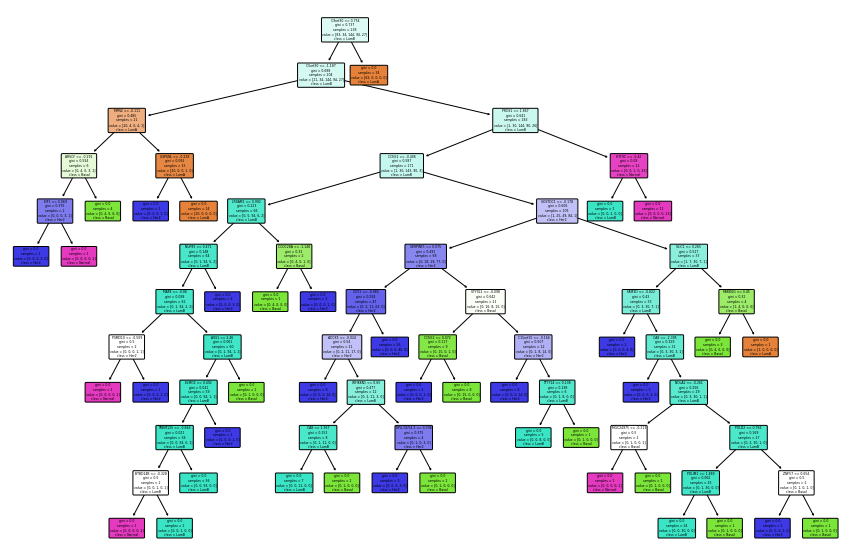

In [ ]:
fig = plt.figure(figsize=(15, 10))
plot_tree(model.estimators_[0], 
          feature_names=X.columns,
          class_names=df_combined['Subtype'].unique(), 
          filled=True, rounded=True)

plt.show()

### Genes Importance given by Random Regressor Classifier

In [ ]:
model.feature_importances_

array([2.40830929e-04, 2.26918085e-03, 5.32656590e-05, ...,
       1.27072493e-03, 2.13752881e-03, 2.16932545e-04])

In [ ]:
X.columns

Index(['ELMO2', 'CREB3L1', 'RPS11', 'PNMA1', 'MMP2', 'C10orf90', 'ZHX3',
       'ERCC5', 'GPR98', 'RXFP3',
       ...
       'GTF2E1', 'RY1', 'ATAD2B', 'ARHGAP17', 'KCNIP3', 'SFPQ', 'GFRA4',
       'AKR1B10', 'TIGD6', 'RGS16'],
      dtype='object', length=1157)

In [ ]:
# sorted descending by importance
df_importance = pd.DataFrame(zip(X.columns, list(model.feature_importances_)), columns=["Gene", "Importance"]).set_index("Gene").sort_values(by="Importance", ascending = False)
df_importance.head(20)

,Importance
Gene,
GABRP,0.017955
C5orf30,0.015469
OGFRL1,0.014712
ROPN1B,0.013607
KIF4A,0.013238
CDT1,0.011620
C6orf66,0.010729
PGR,0.010175
CCNE2,0.009993


In [ ]:
df_subtype["Subtype"].value_counts()

LumA      232
LumB      129
Basal      98
Her2       58
Normal     30
Name: Subtype, dtype: int64